In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
x = pickle.load(open('./data/fundamentals2.pkl', 'rb'))
y = pickle.load(open('./data/performance2.pkl', 'rb'))

In [3]:
print(x.shape)
print(y.shape)

(27105, 74)
(27105, 8)


In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27105 entries, 0 to 27104
Data columns (total 74 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Ticker                                           27105 non-null  object        
 1   Report Date                                      27105 non-null  datetime64[ns]
 2   SimFinId                                         27105 non-null  int64         
 3   Currency                                         27105 non-null  object        
 4   Fiscal Year                                      27105 non-null  int64         
 5   Fiscal Period_x                                  27105 non-null  object        
 6   Publish Date                                     27105 non-null  datetime64[ns]
 7   Restated Date_x                                  27105 non-null  datetime64[ns]
 8   Shares (Basic)_x                    

As there are still some null values, we would need to fix these as any feature engineered ratio could give us an error. Let's fill these null values with zero first.

In [5]:
x = x.fillna(0)

In [6]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27105 entries, 0 to 27104
Data columns (total 74 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Ticker                                           27105 non-null  object        
 1   Report Date                                      27105 non-null  datetime64[ns]
 2   SimFinId                                         27105 non-null  int64         
 3   Currency                                         27105 non-null  object        
 4   Fiscal Year                                      27105 non-null  int64         
 5   Fiscal Period_x                                  27105 non-null  object        
 6   Publish Date                                     27105 non-null  datetime64[ns]
 7   Restated Date_x                                  27105 non-null  datetime64[ns]
 8   Shares (Basic)_x                    

In [7]:
# Add in two new columns
# Market Cap = Shares (Diluted)_x  x Open Price
# EV = Market cap + LT debt + ST debt - Cash
# EBIT = Net Income - Interest Expense - Income Tax (Expense) Benefit, Net

x['Market Cap'] = x['Shares (Diluted)_x'] * y['Open1']
x['EV'] = x['Market Cap'] + x['Long Term Debt'] + x['Short Term Debt'] - x['Cash, Cash Equivalents & Short Term Investments']
x['EBIT'] = x['Net Income'] - x['Interest Expense, Net'] - x['Income Tax (Expense) Benefit, Net']

In [8]:
x.head()

,Ticker,Report Date,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Market Cap,EV,EBIT
0,A,2016-10-31,45846,USD,2016,Q4,2016-12-20,2018-12-20,324000000.0,328000000.0,...,-26000000.0,-78000000.0,-38000000.0,27000000.0,-43000000.0,-56000000.0,90000000,1.421224e+10,1.382724e+10,167000000.0
1,A,2017-01-31,45846,USD,2017,Q1,2017-03-08,2018-03-06,322000000.0,326000000.0,...,-69000000.0,-101000000.0,-42000000.0,89000000.0,-93000000.0,-58000000.0,-48000000,1.566104e+10,1.541204e+10,209000000.0
2,A,2017-04-30,45846,USD,2017,Q2,2017-06-06,2018-05-31,321000000.0,325000000.0,...,0.0,-43000000.0,-43000000.0,52000000.0,-75000000.0,-67000000.0,148000000,1.803750e+10,1.769150e+10,206000000.0
3,A,2017-07-31,45846,USD,2017,Q3,2017-09-06,2018-08-30,321000000.0,326000000.0,...,-57000000.0,-101000000.0,-42000000.0,39000000.0,32000000.0,29000000.0,174000000,1.966432e+10,1.918232e+10,206000000.0
4,A,2017-10-31,45846,USD,2017,Q4,2017-12-21,2018-12-20,324000000.0,327000000.0,...,0.0,-60000000.0,-43000000.0,-70000000.0,8000000.0,-106000000.0,115000000,2.215098e+10,2.148398e+10,239000000.0


In [9]:
# Create a function to feature engineer many different financial ratios
# Takes in original fundamental dataframe then output all the ratio

def getRatios(df):    
    # Create a new dataframe to copy ratios into
    df1 = pd.DataFrame()
    
    # EV/EBIT
    df1['EV_EBIT'] = df['EV']/df['EBIT']

    # Operating Income over (Net working capital + Fidfed assets)
    df1['OI_NWCFA'] = df['Operating Income (Loss)']/\
    (df['Total Current Assets'] - df['Total Current Liabilities'] + df['Property, Plant & Equipment, Net'])

    # Price to earnings
    df1['PE'] = df['Market Cap']/df['Net Income']

    # Price to book
    df1['PB'] = df['Market Cap']/df['Total Equity']

    # Price to sales
    df1['PS'] = df['Market Cap']/df['Revenue']

    # Operating Income over Interest Edfpense
    df1['OI_IntExp'] = df['Operating Income (Loss)']/ -df['Interest Expense, Net']

    # Working Capital Ratio (CA/CL)
    df1['WorkingCap'] = df['Total Current Assets']/ df['Total Current Liabilities']

    # Return on Equity
    df1['ROE'] = df['Net Income']/ df['Total Equity']

    # Return on Capital Employed
    df1['ROCE'] = df['EBIT']/ (df['Total Assets'] - df['Total Current Liabilities'])

    # Debt/Equity
    df1['DE'] = df['Total Liabilities']/ df['Total Equity']

    # Debt Ratio
    df1['DebtRatio'] = df['Total Assets']/ df['Total Liabilities']

    # Cash Ratio
    df1['CashRatio'] = df['Cash, Cash Equivalents & Short Term Investments']/ df['Total Current Liabilities']

    # Asset Turnover
    df1['AssetTurnover'] = df['Revenue']/ df['Property, Plant & Equipment, Net']

    # Gross Profit Margin
    df1['GPM'] = df['Gross Profit']/ df['Revenue']

    # Working Capital over total assets
    df1['WC_TA'] = (df['Total Current Assets'] - df['Total Current Liabilities'])/ df['Total Assets']

    # Retained earnings over total assets
    df1['RE_TA'] = df['Retained Earnings']/ df['Total Assets']

    # EBIT over total assets
    df1['EBIT_TA'] = df['EBIT']/ df['Total Assets']

    # Equity over liabilities
    df1['Equity_Liab'] = df['Total Equity']/ df['Total Liabilities']
    
    return df1

In [10]:
def fixRatios(df):
    '''
    Takes in df, edits it to have the distributions clipped.
    The distribution clippings are done manually by eye,
    with human judgement based on the information.
    '''
    df["ROE"].clip(-5, 5, inplace=True)
    df["OI_NWCFA"].clip(-5, 5, inplace=True)
    df["EV_EBIT"].clip(-500, 500, inplace=True)
    df["PE"].clip(-1000, 1000, inplace=True)
    df["PB"].clip(-50, 100, inplace=True)    
    df["PS"].clip(0, 500, inplace=True)
    df["OI_IntExp"].clip(-600, 600, inplace=True)#-600, 600
    df["WorkingCap"].clip(0, 30, inplace=True)  
    df["ROCE"].clip(-2, 2, inplace=True)
    df["DE"].clip(0, 100, inplace=True)
    df["DebtRatio"].clip(0, 50, inplace=True)  
    df["CashRatio"].clip(0, 30, inplace=True)
    df["AssetTurnover"].clip(-2000, 2000, inplace=True)# 0, 500
    df["GPM"].clip(0, 1, inplace=True) #how can be >100%?
    df["WC_TA"].clip(-1.5, 2, inplace=True)
    df["RE_TA"].clip(-20, 2, inplace=True)
    df["EBIT_TA"].clip(-2, 1, inplace=True)
    df["Equity_Liab"].clip(-2, 20, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

In [11]:
X = getRatios(x)
fixRatios(X)

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
0,82.797844,0.054971,112.795556,3.347207,12.792295,11.437500,3.846561,0.029675,0.024383,0.835610,2.196731,2.422222,1.738654,0.529253,0.345137,0.781242,0.021427,1.196731
1,73.741818,0.064395,93.220476,3.642102,14.677638,12.875000,3.337925,0.039070,0.030812,0.830698,2.203807,2.057851,1.633997,0.537957,0.323425,-0.057546,0.026550,1.203807
2,85.881068,0.061131,109.984756,4.122857,16.367967,13.400000,3.201348,0.037486,0.030165,0.832229,2.201593,2.012637,1.632593,0.537205,0.325973,-0.049027,0.025699,1.201593
3,93.118058,0.057908,112.367543,4.264654,17.651993,15.461538,3.219984,0.037953,0.029345,0.791585,2.263288,2.065270,1.555866,0.535009,0.333495,-0.031473,0.024936,1.263288
4,89.891130,0.063609,125.146780,4.581382,18.629924,17.923077,3.300871,0.036608,0.033366,0.742709,2.346422,2.120348,1.570674,0.544155,0.344885,-0.014954,0.028365,1.346422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27100,117.086405,0.202730,144.590782,22.222597,30.358869,-600.000000,4.114943,0.153693,0.143468,0.552499,2.809959,2.626437,12.526764,0.810819,0.545996,0.429324,0.118320,1.809959
27101,125.173810,0.167461,159.489747,19.780543,27.438661,-600.000000,4.124364,0.124024,0.123484,0.508297,2.967355,2.640850,15.150000,0.808665,0.571065,0.461454,0.100914,1.967355
27102,67.921239,0.204696,90.754714,13.608820,18.885337,600.000000,4.342120,0.149952,0.161655,0.438813,3.278873,2.701559,16.505828,0.800805,0.614245,0.507692,0.131945,2.278873
27103,142.696470,0.117159,124.389828,15.674143,23.990867,600.000000,4.404868,0.126008,0.089747,0.425348,3.351019,2.500000,13.645161,0.776661,0.597917,0.520529,0.073987,2.351019


In [12]:
y.head()

,Ticker1,Open1,Date1,Volume1,Ticker2,Open2,Date2,Volume2
0,A,43.33,2016-10-31,1556762.0,A,67.74,2017-10-31,1609938.0
1,A,48.04,2017-01-31,2552612.0,A,73.77,2018-01-31,1949108.0
2,A,55.50,2017-04-30,1897018.0,A,66.49,2018-04-30,2277705.0
3,A,60.32,2017-07-31,1038744.0,A,64.93,2018-07-31,2539265.0
4,A,67.74,2017-10-31,1609938.0,A,64.35,2018-10-31,3820987.0


In [13]:
# Create function to calculate the stock performance

def getReturns(df):
    '''
    Takes in df, which has the stock prices and respective dates
    Returns a DataFrame y containing the ticker and the 
    relative change in price only ("Returns").
    '''
    y=pd.DataFrame()
    y["Ticker"] = df["Ticker1"]
    y["Returns"] = (df["Open2"]-df["Open1"]) / df["Open2"]
    y["Returns"].fillna(0, inplace=True)
    return y

In [14]:
y = getReturns(y)

## REDO THIS VISUALISATION LATER

In [15]:
# # Make a plot of the distributions.
# cols, rows = 3, 5
# plt.figure(figsize=(5*cols, 5*rows))
# for i in range(1, cols*rows):
#     if i<len(x.keys()):
#         plt.subplot(rows, cols, i)
#         k=x.keys()[i]
#         x[k].hist(bins=100)
#         plt.title(k);

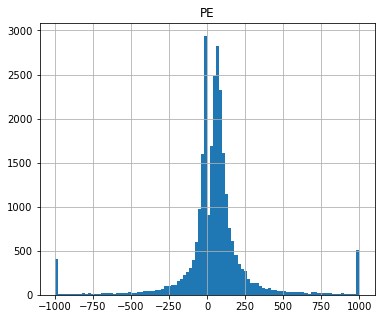

In [16]:
# See one of the distributions
k=X.keys()[2] # Try different numbers, 0-14.
X[k].hist(bins=100, figsize=(6,5))
plt.title(k);

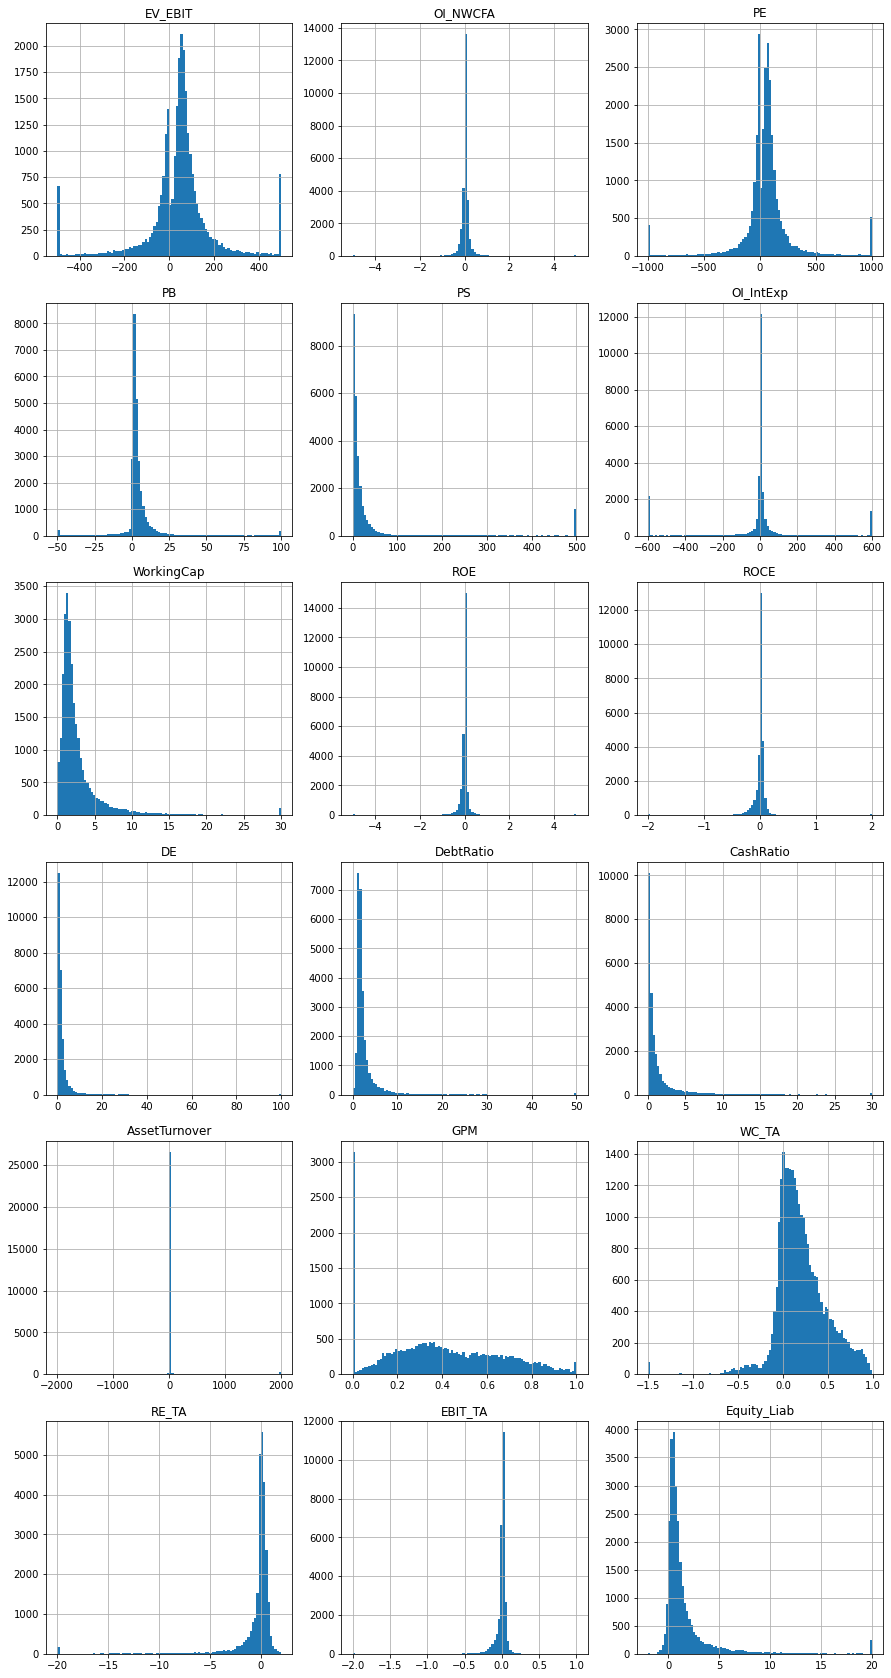

In [17]:
# Make a plot of the distributions.
cols, rows = 3, 6
plt.figure(figsize=(5*cols, 5*rows))

for i in range(0, cols*rows):
    if i<len(X.keys()):
        plt.subplot(rows, cols, i+1)
        k=X.keys()[i]
        X[k].hist(bins=100)
        plt.title(k);

In [18]:
# save to csv
X.to_csv("./data/03_PerformancePct.csv")
y.to_csv("./data/03_FundamentalRatios.csv")

Data does not seem to have good distribution. Try using PowerTransformer to get good distributions and to make data more Gaussian-like.

This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

In [19]:
from sklearn.preprocessing import PowerTransformer

In [20]:
# There are a total of 18 features
X.columns

Index(['EV_EBIT', 'OI_NWCFA', 'PE', 'PB', 'PS', 'OI_IntExp', 'WorkingCap',
       'ROE', 'ROCE', 'DE', 'DebtRatio', 'CashRatio', 'AssetTurnover', 'GPM',
       'WC_TA', 'RE_TA', 'EBIT_TA', 'Equity_Liab'],
      dtype='object')

In [21]:
# Instantiate the PowerTransformer, then fit and transform the data
transformer = PowerTransformer()
X_transformed = pd.DataFrame(transformer.fit_transform(X), columns=X.columns)

# Define function to plot X features
def plotFeatures(feature_index, df):
    feature = df.columns[feature_index]
    plt.hist(df[feature], density=True, bins=30)
    plt.grid()
    plt.xlabel(feature)
    plt.ylabel('Probability')

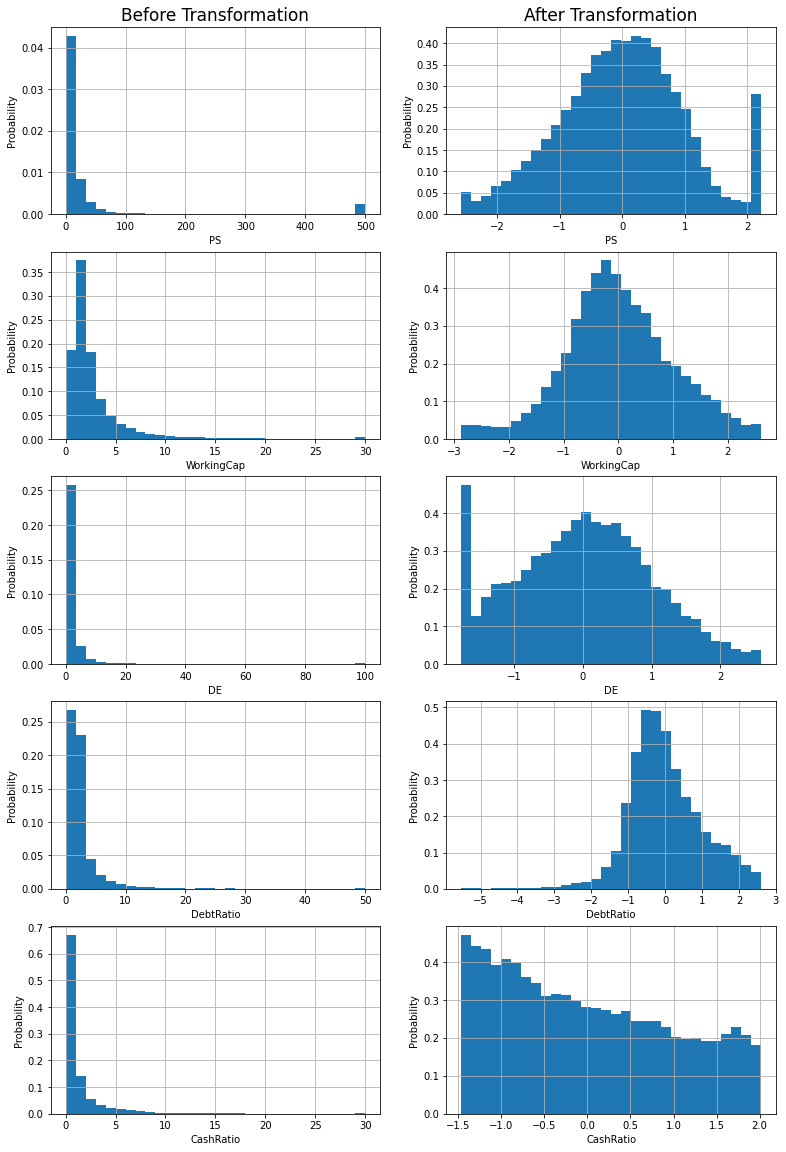

In [22]:
# Visualise some features before and after transformation
plot_list = [4,6,9,10,11] # using indexing

plt.figure(figsize=(13,20))
j=1
for i in plot_list:
    
    # create subplots with number of rows, columns and index (starts with 1)
    plt.subplot(len(plot_list), 2, 2*j-1)
    plotFeatures(i, X)
    if j==1:
        plt.title('Before Transformation',fontsize=17)
    
    plt.subplot(len(plot_list),2,2*j)
    plotFeatures(i, X_transformed)
    if j==1:
        plt.title('After Transformation',fontsize=17)
    j+=1
    
plt.savefig('TransformedFeatures.png', dpi=300)

In [23]:
pickle.dump(X, open('./data/fundamentals3.pkl', 'wb'))
pickle.dump(y, open('./data/performance3.pkl', 'wb'))

In [24]:
# save the final file to csv
X.to_csv("./data/Final_StocksFundamentals.csv")
y.to_csv("./data/Final_StockPerformanceAnnual.csv")